# Instacart Market Basket Analysis

Questions: Customer satisfaction is a major influence factor of customer retention rate. Most of Instacart users are busy people who do not have time going to grocery store on their own. By predicting which products an user will buy again and recommend these products to users during their shopping process, Instacart may offer better convenience to its users. 

In this project, the core question is: Can we increase active customers and customer buying activities by improving the order recommendation system based on their previous orders?
To know when and what should we recommend to each customer, we need to glean some insights on customers’ order placing behaviors. Therefore, we can break down the core question into the following sub-questions: 
1) When should we send our recommendation?

2) How many items should our recommendation contain?

3) What products should we recommend?

## Dataset

In [47]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Import Data
aisels = pd.read_csv('aisles.csv')
dept = pd.read_csv('departments.csv')
order_prior = pd.read_csv('order_products__prior.csv')
order_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [49]:
# EDA

In [50]:
aisels.head() 

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [51]:
aisels.isna().sum(axis = 0) # no missing

aisle_id    0
aisle       0
dtype: int64

In [52]:
dept.head() # dept id and name 

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [53]:
dept.isna().sum(axis = 0) # no missing

department_id    0
department       0
dtype: int64

In [54]:
products.head() #primary product_id, foreign keys: aisle_id, department_id

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [55]:
products.describe() # equal values, no missing 

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [56]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [57]:
print(len(orders))# num of orders
print(orders.user_id.nunique()) #num of customers 

3421083
206209


In [58]:
orders.eval_set.value_counts() # the separation of the database in training and testing. 

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

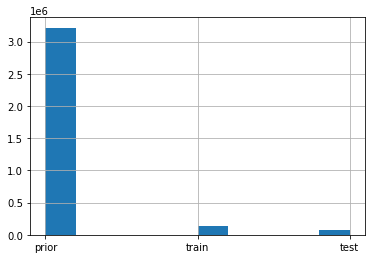

In [59]:
orders['eval_set'].hist()

([<matplotlib.axis.XTick at 0x7fcc46fe6810>,
 <a list of 51 Text major ticklabel objects>)

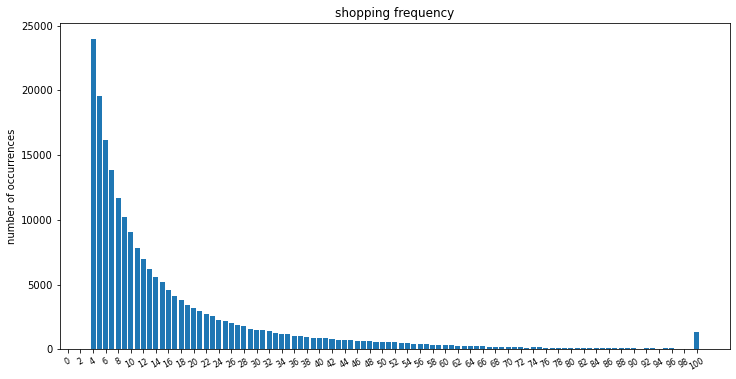

In [60]:
# Distribution of orders 
h = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
h = h.order_number.value_counts()
plt.figure(figsize = (12,6))
plt.bar(h.index, h) 
plt.title('shopping frequency')
plt.ylabel('number of occurrences')
plt.xticks(range(0, 102, 2),size=8, rotation=30)
# order numbers range between 4-100, have a peak on 100 orders 

## shopping habits of customers 

Text(0, 0.5, 'number of occurrence')

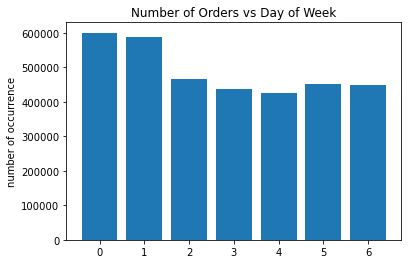

In [61]:
# day of week 
h = orders.order_dow.value_counts()
plt.bar(h.index, h) 
plt.title('Number of Orders vs Day of Week')
plt.ylabel('number of occurrence')
# Sunday monday has the most orders since they're considered the start of week 

Text(0.5, 0, 'hr')

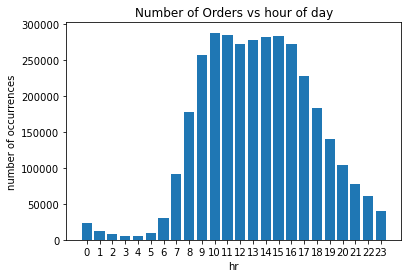

In [62]:
# hour of day 
h = orders.order_hour_of_day.value_counts()
plt.bar(h.index, h)
plt.title('Number of Orders vs hour of day')
plt.xticks(h.index)
plt.ylabel('number of occurrences')
plt.ｘlabel('hr')
# Most orders are during 10am to 4pm 

Text(0.5, 0, 'days')

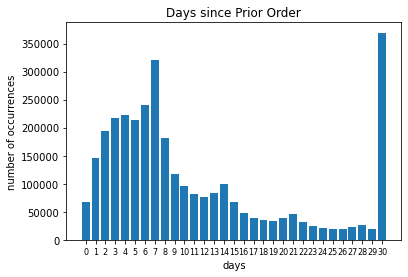

In [63]:
# Days since Prior Order
h = orders.days_since_prior_order.value_counts()
plt.bar(h.index, h) 
plt.title('Days since Prior Order')
plt.xticks(h.index, size=8)
plt.ylabel('number of occurrences')
plt.xlabel('days')
# Reorder frequnency shows increase trend in first 7 days, then decreasing 
# The highest frequency of re-order is once per month, maybe >= 30 days all in this group

## sales of products

In [64]:
# Most Popular Goods
t = order_prior.product_id.value_counts()
t.index = [products[products.product_id==i].product_name.item() for i in t.index]
t.head(20)
# the top 3 are fuits, banana is the bestseller

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_id, dtype: int64

In [65]:
# Most popular aisle
t = pd.DataFrame(order_prior.product_id.value_counts().reset_index())
t.columns = ['product_id', 'count']
t = pd.merge(t, products, on='product_id', how='right')
t = pd.merge(t, aisels, on='aisle_id', how='right')
t.groupby('aisle')['count'].agg(sum).sort_values(ascending=False).head(20) 
# fruit and vegetables aisles are most popular, followed by dairy, water and snacks 

aisle
fresh fruits                     3642188.0
fresh vegetables                 3418021.0
packaged vegetables fruits       1765313.0
yogurt                           1452343.0
packaged cheese                   979763.0
milk                              891015.0
water seltzer sparkling water     841533.0
chips pretzels                    722470.0
soy lactosefree                   638253.0
bread                             584834.0
refrigerated                      575881.0
frozen produce                    522654.0
ice cream ice                     498425.0
crackers                          458838.0
energy granola bars               456386.0
eggs                              452134.0
lunch meat                        395130.0
frozen meals                      390299.0
baby food formula                 382456.0
fresh herbs                       377741.0
Name: count, dtype: float64

## data-preprocessing
predict from customers' previous orders, what products would they reorder? 

In [66]:
order_prior.head() # need to predict the last column reordered or not 1/0

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [67]:
# merge products, aisels, department
print('Processing Products...')
products = pd.merge(products, aisels, on='aisle_id', how='right')
products = pd.merge(products, dept, on='department_id', how='right')
del aisels, dept

Processing Products...


In [68]:
# add user_id column to order_train
order_train = pd.merge(order_train, orders[['order_id', 'user_id']], on='order_id', how='right')

In [69]:
# merge orders, order_prior
orders_products = pd.merge(orders, order_prior, on='order_id', how='inner')
del order_prior

In [70]:
# create prd 
gp = orders_products.groupby('product_id')
prd = pd.DataFrame(gp.size(), columns=['prod_orders']) # numer of times be purchased
prd['prod_reorder'] = gp['reordered'].agg('sum') # number of times be reordered
prd = prd.reset_index()

,product_id,prod_orders,prod_reorder
0,1,1852,1136
1,2,90,12
2,3,277,203
3,4,329,147
4,5,15,9
...,...,...,...
49672,49684,9,1
49673,49685,49,6
49674,49686,120,84
49675,49687,13,6


In [71]:
tmp = orders_products.copy()
gp = orders_products.groupby(['user_id', 'product_id'])
tmp['prod_order'] = gp.cumcount()
prd['prod_1st_orders'] = tmp[tmp['prod_order']==0].groupby('product_id')['prod_order'].count()
prd['prod_2nd_orders'] = tmp[tmp['prod_order']==1].groupby('product_id')['prod_order'].count()
del tmp

In [72]:
# reorder probability 
prd['reorder_prob'] = prd.prod_2nd_orders/prd.prod_1st_orders
prd['reorder_times'] = [i+1 for i in prd.prod_reorder/prd.prod_1st_orders]
# reorder ratio 
prd['reorder_ratio'] = prd.prod_reorder/prd.prod_orders
prd = prd.drop(['prod_reorder', 'prod_1st_orders', 'prod_2nd_orders'], axis=1)
del products

In [73]:
#region < Data Preprocessing: Users >
print('Processing Users')
prior = orders[orders['eval_set'] == 'prior']
gp = prior.groupby('user_id')
users = pd.DataFrame(gp.size(), columns=['user_orders'])
users['period'] = gp['days_since_prior_order'].agg('sum')
users['mean_days_prior'] = gp['days_since_prior_order'].agg('mean')
users = users.reset_index()

Processing Users


In [74]:
users.head()

,user_id,user_orders,period,mean_days_prior
0,1,10,176.0,19.555556
1,2,14,198.0,15.230769
2,3,12,133.0,12.090909
3,4,5,55.0,13.750000
4,5,4,40.0,13.333333


In [76]:
p = orders_products.groupby('user_id')
us = pd.DataFrame(gp.size(), columns=['user_total_products'])
order_number_count = p['order_number'].agg(lambda x: sum(x>1))
reorder_count = p['reordered'].agg('sum')
us['user_reorder_ratio'] = reorder_count/order_number_count
del order_number_count, reorder_count
us['user_distinct_products'] = p['product_id'].nunique()
us = us.reset_index()

users = pd.merge(users, us, on='user_id', how='inner')
users['user_avg_basket'] = users['user_total_products']/users['user_orders']

us = orders.loc[orders['eval_set'] != 'prior', ['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = pd.merge(users, us, on='user_id', how='inner')
del us
print('Done')
print()
#endregion

Done



In [77]:
users.head()

,user_id,user_orders,period,mean_days_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order
0,1,10,176.0,19.555556,10,0.759259,18,1.0,1187899,train,14.0
1,2,14,198.0,15.230769,14,0.510989,102,1.0,1492625,train,30.0
2,3,12,133.0,12.090909,12,0.705128,33,1.0,2774568,test,11.0
3,4,5,55.0,13.750000,5,0.071429,17,1.0,329954,test,30.0
4,5,4,40.0,13.333333,4,0.538462,23,1.0,2196797,train,6.0


In [78]:
#region < Data Preprocessing: Database >
print('Processing Database...')
gp = orders_products.groupby(['user_id', 'product_id'])
dt = pd.DataFrame(gp.size(), columns=['up_orders'])
dt['up_1st_order'] = gp['order_number'].agg('min')
dt['up_last_order'] = gp['order_number'].agg('max')
dt['up_avg_cart_pos'] = gp['add_to_cart_order'].agg('mean')
dt = dt.reset_index()
del orders_products, orders

dt = pd.merge(dt, prd, on='product_id', how='inner')
dt = pd.merge(dt, users, on='user_id', how='inner')

dt['up_order_rate'] = dt['up_orders']/dt['user_orders']
dt['up_orders_since_last'] = dt['user_orders'] - dt['up_last_order']
dt['up_order_rate_since_1st'] = dt['up_orders']/(dt['user_orders']-dt['up_1st_order']+1) 

dt = pd.merge(dt, order_train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
del order_train, prd, users
print('Done')
print()
#endregion

Processing Database...
Done



In [79]:
dt.head()

,user_id,product_id,up_orders,up_1st_order,up_last_order,up_avg_cart_pos,prod_orders,reorder_prob,reorder_times,reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last,up_order_rate_since_1st,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,4.473875,0.776480,...,0.759259,18,1.0,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,3.493716,0.713772,...,0.759259,18,1.0,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,2.873635,0.652009,...,0.759259,18,1.0,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,0.529482,3.857058,0.740735,...,0.759259,18,1.0,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,0.479782,2.916796,0.657158,...,0.759259,18,1.0,1187899,train,14.0,0.3,0,0.333333,1.0


## Modeling

In [80]:
#region < Training & Testing Data >
print('Processing training and testing data')
train = dt[dt['eval_set']=='train']
train = train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)
train['reordered'] = train['reordered'].fillna(0)

test = dt[dt['eval_set']=='test']
test = test.drop(['eval_set', 'user_id', 'reordered'], axis=1)

# del dt
print('Done')
print()
#endregion

Processing training and testing data
Done



In [81]:
import xgboost as xgb

Modeling...
Done



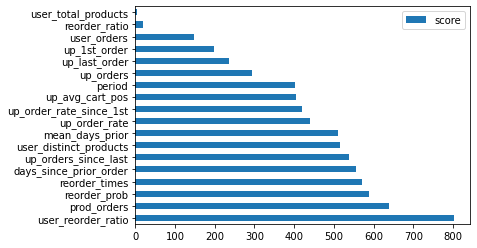

In [82]:
#region < Modeling >
print('Modeling...')
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 10,
    'gamma': 0.7,
    'subsample': 0.76,
    'colsample_bytree': 0.95,
    'alpha': 0.05,
    'lambda': 10
}

subtrain = train.sample(frac=0.1, random_state=2)
X = xgb.DMatrix(subtrain.drop(['reordered'], axis=1), label=subtrain['reordered'])
model = xgb.train(params, X, num_boost_round=160)

importances = model.get_score(importance_type='weight')
importances_keys = list(importances.keys())
importances_vals = list(importances.values())
tmp = pd.DataFrame(data=importances_vals, index=importances_keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.plot(kind='barh')
del tmp
print('Done')
print()
#endregion

In [90]:
subtrain

,up_orders,up_1st_order,up_last_order,up_avg_cart_pos,prod_orders,reorder_prob,reorder_times,reorder_ratio,user_orders,period,mean_days_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,days_since_prior_order,up_order_rate,up_orders_since_last,up_order_rate_since_1st,reordered
13065245,1,6,6,12.0,359,0.117647,1.173203,0.147632,8,198.0,28.285714,8,0.422680,60,1.0,20.0,0.125000,2,0.333333,0.0
1846527,2,7,9,14.5,10345,0.455777,2.747676,0.636056,19,181.0,10.055556,19,0.807560,85,1.0,30.0,0.105263,10,0.153846,0.0
4961349,1,2,2,22.0,10725,0.416474,2.259322,0.557389,4,35.0,11.666667,4,0.392857,52,1.0,0.0,0.250000,2,0.333333,0.0
5292407,2,2,5,17.5,18358,0.468614,2.763510,0.638141,16,183.0,12.200000,16,0.574380,122,1.0,12.0,0.125000,11,0.133333,0.0
13173413,1,8,8,16.0,12,NaN,1.000000,0.000000,11,29.0,2.900000,11,0.278049,168,1.0,2.0,0.090909,3,0.250000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10318117,1,1,1,22.0,16356,0.587935,4.180982,0.760822,5,69.0,17.250000,5,0.545455,97,1.0,11.0,0.200000,4,0.200000,1.0
1748217,1,7,7,21.0,213584,0.668101,4.915288,0.796553,15,268.0,19.142857,15,0.370370,70,1.0,30.0,0.066667,8,0.111111,0.0
10516742,18,1,29,4.0,30055,0.429881,2.257568,0.557045,29,327.0,11.678571,29,0.666667,92,1.0,6.0,0.620690,0,0.620690,1.0
9937337,1,3,3,3.0,185,0.521127,2.605634,0.616216,19,267.0,14.833333,19,0.506250,175,1.0,17.0,0.052632,16,0.058824,0.0


In [87]:
#region < Applying Model > 
print('Predicting...')
X = xgb.DMatrix(test.drop(['order_id', 'product_id'], axis=1))
test['reordered'] = model.predict(X)
test.loc[test['reordered'] > 0.21, 'reordered'] = 1
test
print('Done')
print()

# # pack up products of each order
# print('Creating Submission')
# submission = test[test['reordered']==1]
# submission = submission.groupby('order_id')['product_id'].agg(lambda l: ' '.join([str(i) for i in l]))
# submission = submission.to_frame('products').reset_index()

# # fill missing order_id
# missing_orders = pd.DataFrame(set(test.order_id) - set(submission.order_id), columns=['order_id'])
# missing_orders['products'] = 'None'
#endregion

Predicting...


ValueError: feature_names mismatch: ['up_orders', 'up_1st_order', 'up_last_order', 'up_avg_cart_pos', 'prod_orders', 'reorder_prob', 'reorder_times', 'reorder_ratio', 'user_orders', 'period', 'mean_days_prior', 'user_total_products', 'user_reorder_ratio', 'user_distinct_products', 'user_avg_basket', 'days_since_prior_order', 'up_order_rate', 'up_orders_since_last', 'up_order_rate_since_1st'] ['up_orders', 'up_1st_order', 'up_last_order', 'up_avg_cart_pos', 'prod_orders', 'reorder_prob', 'reorder_times', 'reorder_ratio', 'user_orders', 'period', 'mean_days_prior', 'user_total_products', 'user_reorder_ratio', 'user_distinct_products', 'user_avg_basket', 'days_since_prior_order', 'up_order_rate', 'up_orders_since_last', 'up_order_rate_since_1st', 'reordered']
training data did not have the following fields: reordered

# Parameter Tuning

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

X = subtrain.iloc[:,0:19]
y = subtrain.iloc[:,19]
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

# grid search
model = xgb.XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= 'logloss',
    learning_rate= 0.1,
    max_depth= 6,
    min_child_weight= 10,
    gamma= 0.7,
    subsample= 0.77,
    colsample_bytree= 0.95,
    reg_alpha= 0.05,
    reg_lambda= 10)
n_estimators = range(80, 200, 20)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
	
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs F1")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

In [ ]:
model = XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= 'logloss',
    learning_rate= 0.1,
    min_child_weight= 10,
    gamma= 0.7,
    subsample= 0.77,
    colsample_bytree= 0.95,
    reg_alpha= 0.05,
    reg_lambda= 10)
max_depth = range(0, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
  
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs F1 Score")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('max_depth.png')

In [ ]:
model = XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= 'logloss',
    learning_rate= 0.1,
    min_child_weight= 10,
    max_depth=8,
    subsample= 0.77,
    colsample_bytree= 0.95,
    reg_alpha= 0.05,
    reg_lambda= 10)
gamma = [i/10 for i in range(3, 10)]
print(gamma)
param_grid = dict(gamma=gamma)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# plot
plt.errorbar(gamma, means, yerr=stds)
plt.title("XGBoost gamma vs Log Loss")
plt.xlabel('gamma')
plt.ylabel('Log Loss')
plt.savefig('gamma.png')